In [23]:
import numpy as np
from numpy import pi, log
from astropy.constants import G, M_sun, kpc
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo

In [32]:
(3*(100*cosmo.h/(kpc*u.kpc))**2/(8*np.pi*G) * (kpc*u.kpc)**3 / (Msun*u.Msun)).value

127.34959203408036

In [33]:
class Galaxy():
    """
    Derive a dark matter density profile from a galaxy rotation curve

    Args:
        mvir (float): galaxy virial mass (Msun)
        cvir (float): dark matter concentration parameter (Msun)
    """

    def __init__(self, mvir, cvir, data_vel, data_err, data_r):

        #Define constants
        self.fac = 102

        self.rhocrit = (3*(100*cosmo.h/(kpc*u.kpc))**2/(8*np.pi*G) * (kpc*u.kpc)**3 / (Msun*u.Msun)).value

        # Data arrays
        self.data_vel = data_vel # Velocity
        self.data_err = data_err # Velocity errors
        self.data_r = data_r # Radii

        self.mvir = mvir
        self.cvir = cvir

    def delc(self):
        return (self.fac/3)*self.cvir**3/(np.log(1+self.cvir)-self.cvir/(1+self.cvir))

    def rho_nfw(self):
        #NFW density (virial mass in Msun, concentration parameter)
    
        rv = (self.mvir/((4/3) * np.pi * self.fac * self.rhocrit))**(1/3) 
        rs = rv / self.cvir
        rhos = self.rhocrit*self.delc()
    
        return rhos/((self.data_r/rs)*(1.+(self.data_r/rs))**2.)

    def mass_nfw(self):
        #Enclosed mass (virial mass in Msun, concentration parameter) in Msun
    
        rv = (self.mvir/((4/3) * np.pi * self.fac * self.rhocrit))**(1/3)
        rs = rv / self.cvir
        rhos = self.rhocrit*self.delc()
    
        return 4 * np.pi * rhos * rs**3 * (np.log((self.data_r + rs) / rs) + rs/(self.data_r + rs) - 1) 
    
    def log_like(self, c, log_m_h):
        '''
        Calculate log-likelihood using the data and NFW parameters (c, log10(M_h))
        '''

        # Calculate enclosed mass array with NFW profile
        enclosed_mass = mass_nfw(self.data_r, 10**log_m_h, c)
        # Calculate predicted velocity from v^2 = GM/r
        pred_vel = np.sqrt(G * enclosed_mass / self.data_err)

        # Calculate log-likelihood
        llh = -1/2 * np.sum(((self.data_vel - pred_vel) / self.data_err) ** 2)

        return llh

In [34]:
#Example
rbin = np.arange(0,40,1)
c = 5.
m = 1.
gal = Galaxy(m, c, data_vel=1, data_err=1, data_r=rbin)
mass_nfw = gal.mass_nfw()


Text(0, 0.5, '$M_{NFW}$')

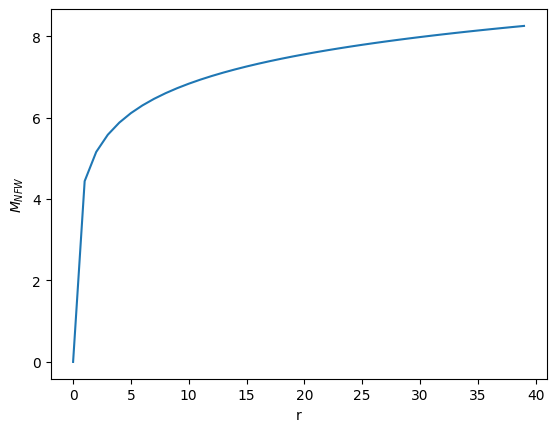

In [35]:
import matplotlib.pyplot as plt
plt.plot(rbin, mass_nfw)
plt.xlabel('r')
plt.ylabel('$M_{NFW}$')